# Semantic Search on Tattoos


## Data preparation


In [61]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import CrossEncoder
from dotenv import load_dotenv
from datasets import Dataset
import pandas as pd
import requests
import torch
import json
import os

load_dotenv()

True

In [62]:
# question = "Give me 3 ideas of a tattoo of a cat in space?"
question = f"Give me very short summary of all tattoos containing owls. Summary must be up to 3 sentences."

In [63]:
image_df = pd.read_csv('../data.csv')[['post_id', 'subreddit', 'image_path']]

old_prefix = '/net/pr2/projects/plgrid/plggtattooai'
new_prefix = '/Users/ewojcik/Code/pwr/AMC/amc-lab3/data'
image_df['image_path'] = image_df['image_path'].str.replace(old_prefix, new_prefix)

image_df

,post_id,subreddit,image_path
0,11tj1ya,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
1,uyp3wc,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
2,de326x,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
3,94gpbt,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
4,108rdjd,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
...,...,...,...
78618,18k69hq,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
78619,1ba61b8,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
78620,1cea717,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
78621,12b3npz,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...


In [64]:
descriptions_df = pd.read_csv('../data.csv')[['post_id', 'tattoo_description','tattoo_color', 'tattoo_style', 'Title']]
descriptions_df

,post_id,tattoo_description,tattoo_color,tattoo_style,Title
0,11tj1ya,blackwork tattoo with intricate designs on the...,black,blackwork,Palm sleeves tattoos done by Chris at Timeless...
1,uyp3wc,colorful illustrative tattoo with various shap...,multicolored,illustrative,How it started and how its going. A map to esc...
2,de326x,blackwork tattoo featuring two raccoons with g...,black,blackwork,"Raccoon and otter by Shaun Horlock, Black Lodg..."
3,94gpbt,a watercolor tattoo of a landscape scene withi...,blue,illustrative,Got my first tattoo in four years from the ama...
4,108rdjd,animestyle tattoo with red tears and black eye...,red black,anime,"My Kill Bill thigh piece, by Nikol Safronova a..."
...,...,...,...,...,...
78618,18k69hq,a traditional tattoo featuring a heart with ey...,red black yellow,traditional,does this look normal?
78619,1ba61b8,black floral tattoo on the arm,black,blackwork,how much to tip
78620,1cea717,black fine line floral tattoo on the inner for...,black,fine line,First Tattoo is missing something...
78621,12b3npz,blackwork floral and butterfly tattoo on the r...,black,blackwork,Is it too jumbled up? I like it sometimes and ...


### Merge Posts


In [65]:
if not os.path.exists('../tattoos/posts_content.csv'):
    # Get all CSV files in the specified directory
    csv_path = '../tattoos/posts_per_subreddit'
    csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

    # Initialize empty DataFrame
    posts_content_df = pd.DataFrame()

    # Read and concatenate each CSV file
    for file in csv_files:
        file_path = os.path.join(csv_path, file)
        df = pd.read_csv(file_path)
        posts_content_df = pd.concat([posts_content_df, df], ignore_index=True)

    posts_content_df = posts_content_df[['Id', 'Content']]
    # Replace NaN values in 'Content' column with empty string
    posts_content_df['Content'] = posts_content_df['Content'].fillna('')
    posts_content_df = posts_content_df.rename(columns={'Id': 'post_id'})

    posts_content_df.to_csv('../tattoos/posts_content.csv')
else:
    posts_content_df = pd.read_csv('../tattoos/posts_content.csv')
    # Replace NaN values in 'Content' column with empty string
    posts_content_df['Content'] = posts_content_df['Content'].fillna('')

In [66]:
posts_content_df

,Unnamed: 0,post_id,Content
0,0,2zbp4x,
1,1,2zeq1l,
2,2,2zfjp4,
3,3,2zizqs,
4,4,2zlsqy,
...,...,...,...
332450,332450,1gk2hyh,
332451,332451,1gk33iq,"This is my second tattoo ever, I decided to ge..."
332452,332452,1gk34gz,
332453,332453,1gk37w5,


### Join Posts and Descriptions


In [67]:
tattoos_df = pd.merge(descriptions_df, posts_content_df, on='post_id', how='left')
tattoos_df


,post_id,tattoo_description,tattoo_color,tattoo_style,Title,Unnamed: 0,Content
0,11tj1ya,blackwork tattoo with intricate designs on the...,black,blackwork,Palm sleeves tattoos done by Chris at Timeless...,273511,
1,uyp3wc,colorful illustrative tattoo with various shap...,multicolored,illustrative,How it started and how its going. A map to esc...,261900,
2,de326x,blackwork tattoo featuring two raccoons with g...,black,blackwork,"Raccoon and otter by Shaun Horlock, Black Lodg...",215506,
3,94gpbt,a watercolor tattoo of a landscape scene withi...,blue,illustrative,Got my first tattoo in four years from the ama...,192953,
4,108rdjd,animestyle tattoo with red tears and black eye...,red black,anime,"My Kill Bill thigh piece, by Nikol Safronova a...",270201,
...,...,...,...,...,...,...,...
78618,18k69hq,a traditional tattoo featuring a heart with ey...,red black yellow,traditional,does this look normal?,30635,so i have several tattoos but i’ve never had c...
78619,1ba61b8,black floral tattoo on the arm,black,blackwork,how much to tip,38301,how much of a tip should you leave on a $480 t...
78620,1cea717,black fine line floral tattoo on the inner for...,black,fine line,First Tattoo is missing something...,43349,I got my first tattoo last month (got 2 fine l...
78621,12b3npz,blackwork floral and butterfly tattoo on the r...,black,blackwork,Is it too jumbled up? I like it sometimes and ...,14909,


In [68]:
tattoos_df.dropna(inplace=True, ignore_index=True)
tattoos_df.isnull().sum()


post_id               0
tattoo_description    0
tattoo_color          0
tattoo_style          0
Title                 0
Unnamed: 0            0
Content               0
dtype: int64

In [69]:

tattoos_dataset = Dataset.from_pandas(tattoos_df)
tattoos_dataset


Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content'],
    num_rows: 78233
})

In [70]:
def concatenate_text(examples):
    return {
        "text": examples["Title"]
        + " \n "
        + examples["Content"]
        + " \n "
        + examples["tattoo_description"]
        + " \n "
        + examples["tattoo_color"]
        + " \n "
        + examples["tattoo_style"]
    }


tattoos_dataset = tattoos_dataset.map(concatenate_text)
tattoos_dataset

Map:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text'],
    num_rows: 78233
})

In [71]:
tattoos_dataset = tattoos_dataset.map(
    lambda x: {"text_length": len(x["text"].split())}
)
tattoos_dataset

Map:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length'],
    num_rows: 78233
})

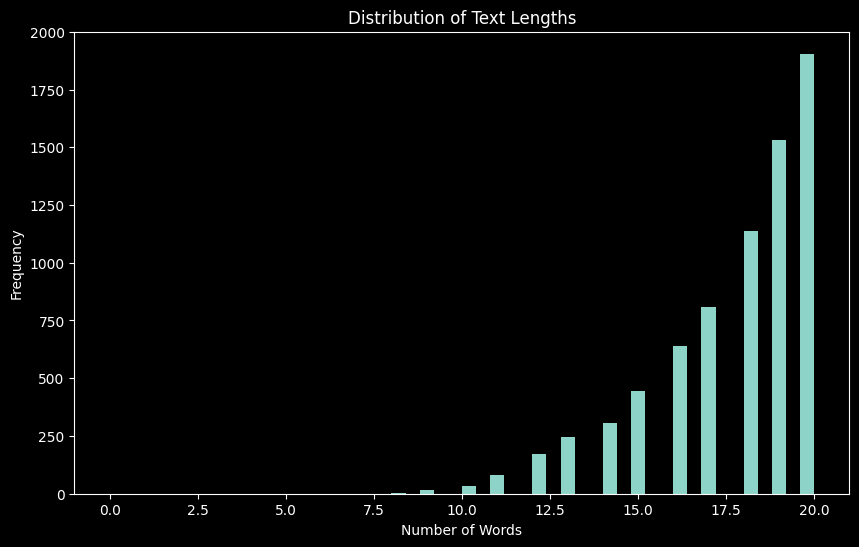

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(tattoos_dataset['text_length'], bins=50, range=(0,20))
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [73]:
tattoos_dataset = tattoos_dataset.filter(lambda x: x["text_length"] > 15)
tattoos_dataset

Filter:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length'],
    num_rows: 76931
})

## Retriever


### Embeddings


In [74]:
model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [76]:
def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

In [77]:
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [78]:
embedding = get_embeddings(tattoos_dataset["text"][0])
embedding.shape


torch.Size([1, 768])

In [79]:
if os.path.exists("../data/tattoos_embeddings"):
    embeddings_dataset = Dataset.load_from_disk("../data/tattoos_embeddings")
else:
    embeddings_dataset = tattoos_dataset.map(
        lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
    )
    # Create data directory if it doesn't exist
    os.makedirs("../data", exist_ok=True)
    # Save the dataset with embeddings 
    embeddings_dataset.save_to_disk("../data/tattoos_embeddings")

### Faiss Index


In [80]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/77 [00:00<?, ?it/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length', 'embeddings'],
    num_rows: 76931
})

In [81]:

question_embedding = get_embeddings([question]).cpu().detach().numpy()
question_embedding.shape

(1, 768)

In [82]:
scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", question_embedding, k=15
)

In [83]:
samples_df = pd.DataFrame.from_dict(samples)
samples_df["scores"] = scores
samples_df.sort_values("scores", ascending=False, inplace=True)

In [84]:
for _, row in samples_df.iterrows():
    print(f"SCORE: {row.scores}")
    print(f"DESCRIPTION: {row.tattoo_description}")
    print(f"COLOR: {row.tattoo_color}")
    print(f"STYLE: {row.tattoo_style}")
    print(f"CONTENT: {row.Content}")
    print(f"TITLE: {row.Title}")
    print("=" * 50)
    print()

SCORE: 28.84750747680664
DESCRIPTION: blackwork owl with geometric elements on shoulder
COLOR: black
STYLE: blackwork
CONTENT: 
TITLE: Pixelated owl tattoo made by me @mikestatuering at Big time tattoo Sweden. 

SCORE: 28.735153198242188
DESCRIPTION: black owl with red eyes and geometric shapes on skin
COLOR: black
STYLE: realism
CONTENT: 
TITLE: Insane owl tattoo by Michael Stade at Big Time Tattoo, Västerås, Sweden. IG @mikestatuering

SCORE: 28.489686965942383
DESCRIPTION: black and white owl tattoo with moon phases and leaves
COLOR: black
STYLE: realism
CONTENT: 
TITLE: My owl in progress done by Alina Bushman at Golden Eagle Tattoo Parlor, Essen Germany

SCORE: 28.402420043945312
DESCRIPTION: black and white pointillism owl tattoo on the arm
COLOR: black
STYLE: pointillism
CONTENT: 
TITLE: My first tattoo, an absolutely stunning sketchy barn owl based on a drawing done by my best friend

SCORE: 28.388254165649414
DESCRIPTION: a detailed tattoo featuring a red owl with a mazelike p

## Re-ranker


In [85]:
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")

In [86]:
scores_re_ranker = model.predict([(question, row.text) for _, row in samples_df.iterrows()])
samples_df["scores_re_ranker"] = scores_re_ranker
samples_df.sort_values("scores_re_ranker", ascending=False, inplace=True)
samples_df

,post_id,tattoo_description,tattoo_color,tattoo_style,Title,Unnamed: 0,Content,text,text_length,embeddings,scores,scores_re_ranker
0,os60hp,colorful owl with wings spread perched on a fi...,multicolored,illustrative,Owl tattoo I did a while ago :),84092,,Owl tattoo I did a while ago :) \n \n colorfu...,22,"[0.1494920551776886, -0.40732789039611816, -0....",24.394688,0.847438
3,10vc3wn,a detailed owl tattoo with a sun and stars in ...,multicolored,illustrative,Owl Tattoo by Mark Strong (Studio Ink on East ...,271593,,Owl Tattoo by Mark Strong (Studio Ink on East ...,25,"[0.18000249564647675, -0.33048394322395325, -0...",26.400852,0.080747
2,685qbf,black and white pointillism tattoo featuring a...,black,pointillism,The owls are not what they seem! By Prakash at...,173421,,The owls are not what they seem! By Prakash at...,28,"[0.5619108080863953, -0.265142560005188, -0.25...",26.067162,-0.023022
9,8t3dlb,a detailed black and grey tattoo featuring two...,black gray,realism,Noticed a lot of Owl tattoos posted lately so ...,1361,,Noticed a lot of Owl tattoos posted lately so ...,32,"[0.3654405176639557, -0.1877894103527069, -0.2...",28.273754,-0.571226
14,1djoka5,blackwork owl with geometric elements on shoulder,black,blackwork,Pixelated owl tattoo made by me @mikestatuerin...,9509,,Pixelated owl tattoo made by me @mikestatuerin...,21,"[0.31954747438430786, -0.5457841753959656, -0....",28.847507,-0.817700
10,tcjmnl,a detailed tattoo featuring a red owl with a m...,red black,illustrative,Abstract owl. Done by me. Los Angeles. Insta: ...,6754,,Abstract owl. Done by me. Los Angeles. Insta: ...,23,"[0.38785967230796814, -0.24817177653312683, -0...",28.388254,-0.957415
12,77suvz,black and white owl tattoo with moon phases an...,black,realism,My owl in progress done by Alina Bushman at Go...,180271,,My owl in progress done by Alina Bushman at Go...,27,"[0.32483047246932983, -0.2204589545726776, -0....",28.489687,-0.957562
4,4zaxj1,a detailed owl tattoo with floral elements and...,black white,illustrative,"Posted here 5 months ago, all finished now!",365,,"Posted here 5 months ago, all finished now! \n...",22,"[0.2633666396141052, -0.20922726392745972, -0....",26.808929,-0.987584
6,tyctq9,a detailed tattoo featuring various illustrati...,black,illustrative,need some tattoo advices here…,91118,,need some tattoo advices here… \n \n a detail...,23,"[0.37786534428596497, -0.2570452094078064, -0....",27.004406,-1.044963
1,75l86g,colorful owl tattoo with geometric and abstrac...,multicolored,traditional,First post here. Did this owl today. Thanks fo...,823,,First post here. Did this owl today. Thanks fo...,20,"[0.2247302383184433, -0.38828301429748535, -0....",26.061811,-1.100969


# RAG


In [87]:
k_for_rag = 10
top_k_docs = samples_df.head(k_for_rag)
context = "\n\n".join(top_k_docs["text"].tolist())

In [93]:
prompt = f"""
Context information is below.
---------------------
{context}
---------------------
Given the context information and not prior knowledge, answer the query.
Question: {question}
Answer in polish:
"""

print(prompt)


Context information is below.
---------------------
Owl tattoo I did a while ago :) 
  
 colorful owl with wings spread perched on a fire with tree stumps 
 multicolored 
 illustrative

Owl Tattoo by Mark Strong (Studio Ink on East 7th ATX) 
  
 a detailed owl tattoo with a sun and stars in the background 
 multicolored 
 illustrative

The owls are not what they seem! By Prakash at Gallon Tattoo, Stockholm, Sweden 
  
 black and white pointillism tattoo featuring an owl and a forest landscape 
 black 
 pointillism

Noticed a lot of Owl tattoos posted lately so thought I'd share mine. [Alexis Vaatete of Vatican Studios] 
  
 a detailed black and grey tattoo featuring two owls in flight 
 black gray 
 realism

Pixelated owl tattoo made by me @mikestatuering at Big time tattoo Sweden.  
  
 blackwork owl with geometric elements on shoulder 
 black 
 blackwork

Abstract owl. Done by me. Los Angeles. Insta: @nlucastattoo 
  
 a detailed tattoo featuring a red owl with a mazelike pattern 
 

In [94]:
url = "https://services.clarin-pl.eu/api/v1/oapi/chat/completions"
user_token = os.getenv('CLARIN_API_TOKEN')


headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {user_token}",
    "Content-Type": "application/json"
}

payload = {
    "model": "llama",
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ]
}

response = requests.post(url, headers=headers, json=payload)

In [95]:
if response.status_code == 200:
    data = response.json()

    assistant_message = data['choices'][0]['message']['content']
    print(assistant_message)

else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    print("Response:", response.text)

Krótki podsumowanie wszystkich wymienionych tatuaży z motywem sowy:

1. Tatuaże przedstawiają różnorodne style i techniki artystyczne, od realistycznych po abstrakcyjne i geometryczne.
2. Kolorystyka jest bogata - od czerni i szarości po żywe barwy i gradacje tonów.
3. Motywy dodatkowe często obejmują pejzaże leśne, zwierzęta, symbole oraz elementy tradycyjnego tatuażu.
